<img src="ivan_coffee_2.png" width=100 height=100 align="right">

Author: Group G

Last revision: 24/February/2021

In [ ]:
!git clone https://github.com/ipolakovic/EDA_Video.git

Cloning into 'EDA_Video'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

Welcome to the GROUP VIDEO starter code.

Your group task is to record a video of 10 - 15 minutes CLEANING DATA and DEVELOPING 2 MODELS using the RBA_KYC_Accounts_ALL_Ids.xlsx dataset. You should use Pandas, Matplotlib and Scikit Learn (Sklearn) libraries only if possible. Your video should include:

* A quick explanation of Pandas, Matplotlib and Sklearn, specially including their histories. (less than a minute)
* A quick Exploratory Data Analysis of the data set used.
* Using the EDA, explain the problems of data quality in this data set.
* Research about data preparation with Python. Propose and implement ways to clean, input missing and prepare the data for modelling. (YOUR VIDEO SHOULD FOCUS IN THIS PART - 70-80% OF THE VIDEO SHOULD BE ABOUT DATA CLEANING AND DATA PREPARATION)
* Then, develop one Regression model using rbaValue as target variable.  Remember to assess the model performance using an appropriate measure for regression. 
* Then, develop one binary Classification model using Risk_Description setting Risk_Description = Low as 0 and else 1 (Medium or High). Remember to assess your model performance using a appropriate measure for classification.

ps. please, don't improve the model, you don't need to make good one, simply do a quick one! This exercise is about explaining, in a video lecture, how to prepare the data for modelling , not about making a good model .

ps. You can apply any of the steps in the model development seing in the last class, but be coincious of time it may take to do it all, so avoid overcomplicating things.

Please find below couple videos from previous years (different data set and different objective) and from which you'll also learn some Python ideas:

* 2018 MBD01 Group E Variable Transformation - https://www.youtube.com/watch?v=j_0HQ2UF_L0
* 2019 - Risk & Fraud Analytics - Scikit Learn & Lending Club - Group C - https://www.youtube.com/watch?v=oTmHMXsksM8

# Structure

### 1. Import libraries and datasets
### 2. Rework metadata in order to have one consolidated DF for it
### 3. EDA
### 4. Data cleansing
####----4.1 Nulls
####----4.2 Imputting values
####----4.3 Further error analysis
####----4.4 Plots and column classification
####----4.5 Outliers
### 5. Feature Engineering / Selection 
####----5.1 Skewness
####----5.2 Correlation
####----5.3 One hot Encoding for discrete variables
####----5.4 Data types and Label Encoding
####----5.5 Check for negative values in positive columns (such as deposits)
### 6. Classification Model and feature importance
### 6.1 Regression Model and feature importance

In [145]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime
# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
# Machine learning
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score
import numpy as np





### 1. Import the database: RBA_KYC_Accounts_ALL_Ids.xlsx

In [146]:
import pandas as pd
df_backup = pd.read_excel("/content/drive/My Drive/Python_Group_Assignment/RBA_KYC_Accounts_ALL_Ids.xlsx")

In [147]:
df = df_backup.copy()

### 2. Import the metadata

##### Due to sheets having different column names, we first import all except Profession, we then deal with it so we can concatenate and have a consolidated metadata dataframe

In [148]:
sheets_dict = pd.read_excel("/content/drive/My Drive/Python_Group_Assignment/RBA Metadata.xlsx",sheet_name=None)

full_table = pd.DataFrame()
for name, sheet in sheets_dict.items():
    sheet['sheet'] = name
    sheet = sheet.rename(columns=lambda x: x.split('\n')[-1])
    full_table = full_table.append(sheet)

full_table.reset_index(inplace=True, drop=True)

full_table = full_table.iloc[:,3:7]
full_table = full_table[full_table['sheet']!= "Profession"]
full_table

,sheet,code,value,dsc
43,Company Type,Company_Type,51,Company
44,Ledgers,RBA_Ledger_High,1041,ارصده لدى بنوك خارج المملكه / اشعار
45,Ledgers,RBA_Ledger_High,1050,شيكات برسم القبض (اوراق مشتراه)
46,Ledgers,RBA_Ledger_High,1120,استثمارات فى الاسهم
47,Ledgers,RBA_Ledger_High,1121,إستثمارات في الأسهم/خارجية
...,...,...,...,...
1265,Currencies,RBA_Currency_Med,SKK,Kron Slovaki
1266,Currencies,RBA_Currency_Med,THB,Baht
1267,Currencies,RBA_Currency_Med,TND,Tunisian Dinar
1268,Currencies,RBA_Currency_Med,TWD,New Taiwan Dollar


In [149]:
metadata_profession = pd.read_excel("/content/drive/My Drive/Python_Group_Assignment/RBA Metadata.xlsx",sheet_name = "Profession")
metadata_profession = metadata_profession.rename(columns = {"Code":"code","Value":"value","Description":"dsc"})
metadata_profession["sheet"] = "Profession"
cols = list(metadata_profession.columns)  ## due to columns not being ordered for merging, we arrange the order
cols = [cols[-1]] + cols[:-1]
metadata_profession = metadata_profession[cols]
metadata_profession

,sheet,code,value,dsc
0,Profession,RBA_PROF_High,12,رئيس مجلس ادارة
1,Profession,RBA_PROF_High,13,نائب رئيس مجلس ادارة
2,Profession,RBA_PROF_High,14,عضو مجلس ادارة
3,Profession,RBA_PROF_High,15,مدير عام
4,Profession,RBA_PROF_High,16,نائب مدير عام
5,Profession,RBA_PROF_High,27,موظف بنك
6,Profession,RBA_PROF_High,29,محاسب
7,Profession,RBA_PROF_High,30,وزير
8,Profession,RBA_PROF_High,31,قاضي
9,Profession,RBA_PROF_High,32,سفير


In [150]:
# our final metadata table
frames = [metadata_profession,full_table]
metadata_full_table = pd.concat(frames)
metadata_full_table

,sheet,code,value,dsc
0,Profession,RBA_PROF_High,12,رئيس مجلس ادارة
1,Profession,RBA_PROF_High,13,نائب رئيس مجلس ادارة
2,Profession,RBA_PROF_High,14,عضو مجلس ادارة
3,Profession,RBA_PROF_High,15,مدير عام
4,Profession,RBA_PROF_High,16,نائب مدير عام
...,...,...,...,...
1265,Currencies,RBA_Currency_Med,SKK,Kron Slovaki
1266,Currencies,RBA_Currency_Med,THB,Baht
1267,Currencies,RBA_Currency_Med,TND,Tunisian Dinar
1268,Currencies,RBA_Currency_Med,TWD,New Taiwan Dollar


In [151]:
# we will replace the values in 'sheet' so they match our main df and we can work with both dfs
metadata_full_table["sheet"].replace({"Profession": "profession", "Company Type": "companytype","Ledgers": "ledgercode","Cus_Class": "cus_class","ECO_SEC": "eco_sec","Type_Of_DEP": "type_of_dep","Legal_STA_Code": "legal_sta_code","COUNTRIES": "residentcountry","Currencies": "accountcurrency"}, inplace=True)

## 3. EDA

In [152]:
df.head()

,org_code,branchCode,customerId,fullaccount,customerType,creationDate,onboarding,residentStatus,residentCountry,nationalityOriginal,extraNationality,dateOfBirth,age_in_year,birthCountry,birthPlace,profession,companyType,giinCode,lastUpdate,status,ledgerCode,accountCurrency,jointAccount,IsBlackListed,CUS_CLASS,ECO_SEC,TYPE_OF_DEP,GENDER,LEGAL_STA_CODE,legal_Stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,date_of_assessment,rbaGradeAbrv,rba_grade_desc,score_card,score_card_Desc,rbaValue
0,1,201,20100400550000072,020100400550015817000,2,2015-04-05,N,1,JO,JO,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,Active,5817,JOD,0,0,4,46,35,NaN,2.0,NaN,8610000.00,2170000.00,23333.33,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,Low,E-Existing,NaN,13.20
1,1,202,20200207860000638,020200207860011330000,1,2013-09-17,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,1330,JOD,0,0,2,90,23,2.0,1.0,NaN,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,Low,I-Existing,NaN,16.93
2,1,202,20200207860000638,020200207860011389002,1,2013-09-17,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,1389,JOD,0,0,2,90,23,2.0,1.0,NaN,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,Low,I-Existing,NaN,16.93
3,1,202,20200207860000638,020200207860010060000,1,2013-09-17,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,60,JOD,0,0,2,90,23,2.0,1.0,NaN,2079.79,526.87,6.68,4,-550.0,4,-550.0,1,50.0,1,50.0,2019-01-24,L,Low,I-Existing,NaN,16.93
4,1,202,20200207860000638,020200207860010010000,1,2013-09-17,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,10,JOD,0,0,2,90,23,2.0,1.0,NaN,444.00,120.50,0.95,4,-540.0,4,-540.0,1,56.0,1,56.0,2019-01-24,L,Low,I-Existing,NaN,16.93


#### We want columns names across both data sets to  be standardized

In [153]:
df.columns = df.columns.str.lower()

In [154]:
df.describe()

,org_code,branchcode,customerid,customertype,residentstatus,age_in_year,birthcountry,profession,companytype,lastupdate,ledgercode,jointaccount,isblacklisted,cus_class,eco_sec,type_of_dep,gender,legal_sta_code,legal_stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,score_card_desc,rbavalue
count,224868.0,224868.000000,2.248680e+05,224868.000000,224868.000000,220153.000000,0.0,79748.000000,114574.000000,0.0,224868.000000,224868.000000,224868.0,224868.000000,224868.000000,224868.000000,104357.000000,222252.000000,0.0,2.248680e+05,2.248680e+05,224868.000000,224868.000000,2.248680e+05,224868.000000,2.248680e+05,224868.000000,2.248680e+05,224868.000000,2.248680e+05,0.0,224868.000000
mean,1.0,448.451323,4.394503e+16,1.114418,1.021221,41.310575,NaN,18.309487,49.857577,NaN,1059.328757,0.021653,0.0,3.765231,89.388632,35.509014,1.250975,1.193564,NaN,7.832261e+03,1.988950e+03,18.871381,0.491422,-1.113435e+03,1.131437,-3.540383e+03,0.254305,4.763851e+02,0.868518,2.450953e+03,NaN,17.624194
std,0.0,228.193308,2.349321e+16,0.318319,0.144122,16.000536,NaN,6.586481,6.736115,NaN,1280.875258,0.145547,0.0,4.305015,29.406849,15.491855,0.433576,0.528191,NaN,1.325116e+06,3.344322e+05,3685.041168,5.335240,3.028084e+04,19.713739,9.151602e+04,1.175586,2.028110e+04,12.373992,5.819818e+04,NaN,8.368345
min,1.0,201.000000,2.020028e+09,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,NaN,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,NaN,-1.791005e+08,-4.513426e+07,-485686.730000,0.000000,-5.482044e+06,0.000000,-1.654371e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,4.080000
25%,1.0,208.000000,2.070207e+16,1.000000,1.000000,31.000000,NaN,20.000000,51.000000,NaN,20.000000,0.000000,0.0,2.000000,90.000000,20.000000,1.000000,1.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,13.330000
50%,1.0,401.000000,4.011205e+16,1.000000,1.000000,41.000000,NaN,20.000000,51.000000,NaN,1302.000000,0.000000,0.0,2.000000,90.000000,35.000000,1.000000,1.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,16.530000
75%,1.0,701.000000,7.012410e+16,1.000000,1.000000,52.000000,NaN,21.000000,51.000000,NaN,1396.000000,0.000000,0.0,2.000000,90.000000,51.000000,2.000000,1.000000,NaN,6.914525e+02,1.826150e+02,1.100000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,21.330000
max,1.0,805.000000,8.052929e+16,2.000000,2.000000,119.000000,NaN,39.000000,100.000000,NaN,8700.000000,1.000000,0.0,51.000000,392.000000,100.000000,2.000000,4.000000,NaN,1.531514e+08,3.859913e+07,415044.440000,1267.000000,0.000000e+00,3292.000000,5.867291e+05,78.000000,8.394000e+06,2858.000000,9.942530e+06,NaN,100.000000


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224868 entries, 0 to 224867
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   org_code                    224868 non-null  int64  
 1   branchcode                  224868 non-null  int64  
 2   customerid                  224868 non-null  int64  
 3   fullaccount                 224868 non-null  object 
 4   customertype                224868 non-null  int64  
 5   creationdate                224868 non-null  object 
 6   onboarding                  224868 non-null  object 
 7   residentstatus              224868 non-null  int64  
 8   residentcountry             224272 non-null  object 
 9   nationalityoriginal         221429 non-null  object 
 10  extranationality            1793 non-null    object 
 11  dateofbirth                 220153 non-null  object 
 12  age_in_year                 220153 non-null  float64
 13  birthcountry  

#### Creating the variable risk_description

In [156]:
df['risk_description'] = df['rba_grade_desc'] # here we just change the name of the column
df.drop(['rba_grade_desc'], axis = 1, inplace = True) 

#### Creating the variable creationdate_indays and casting to integer

In [157]:
df['creationdate'].value_counts()

2013-11-20    1079
1994-05-18     951
2014-12-31     889
2010-07-28     714
2016-08-04     600
              ... 
1992-06-07       1
1985-02-07       1
1996-09-09       1
1986-08-09       1
1987-09-24       1
Name: creationdate, Length: 7041, dtype: int64

In [158]:
df['creationdate_indays'] = df['creationdate'].astype('datetime64[ns]').max()-df['creationdate'].astype('datetime64[ns]') 
df['creationdate_indays'].head()

0   1295 days
1   1860 days
2   1860 days
3   1860 days
4   1860 days
Name: creationdate_indays, dtype: timedelta64[ns]

In [159]:
df['creationdate_indays'] = df['creationdate_indays'].dt.days

In [160]:
df['creationdate_indays']

0         1295
1         1860
2         1860
3         1860
4         1860
          ... 
224863     364
224864    5199
224865    6633
224866    3931
224867    1103
Name: creationdate_indays, Length: 224868, dtype: int64

In [161]:
df= df.drop(columns='creationdate')


#### Creating the variable date of birth

#### calculating this using the most recent date of birth vs others

In [162]:
from dateutil.relativedelta import *

In [163]:
def f(end):
    global max_date
    try:
        r = relativedelta(max_date, end) 
        return(r.years)
    except:
        return(0)

    # r = relativedelta(pd.to_datetime('now'), end) 
    # return '{} years {} days'.format(r.years, r.days)

#### We believe this might be wrong, the max date should be the date of assessment and not the last person born.

In [164]:
max_date_old = df['dateofbirth'].astype('datetime64[ns]').max()
max_date_old ## this is the youngest, most recent date



Timestamp('2018-10-15 00:00:00')

In [165]:
max_date = df['date_of_assessment'].astype('datetime64[ns]')[0]
max_date

Timestamp('2019-01-24 00:00:00')

In [166]:
df['age'] = df['dateofbirth'].astype('datetime64[ns]').apply(f)
df['age'].head()

0     0
1    29
2    29
3    29
4    29
Name: age, dtype: int64

In [167]:
df['age'].value_counts()

35     6035
37     6015
39     5780
38     5767
34     5594
       ... 
103       1
102       1
100       1
99        1
97        1
Name: age, Length: 108, dtype: int64

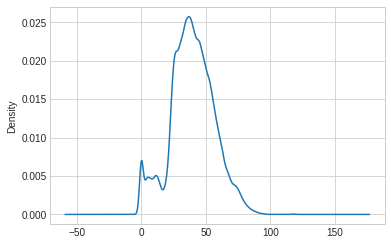

In [168]:
df.age.plot(kind='kde')

#### Profile Report (didnt work becuase of RAM capacity of Google Collab)

In [ ]:
# !pip install pandas_profiling


In [ ]:
# from pandas_profiling import ProfileReport
# report = ProfileReport(df.iloc[:, 0:23], minimal=False)
# report

## 4. Data cleansing
## 4.1 Nulls
#### Check visually for nulls in every row

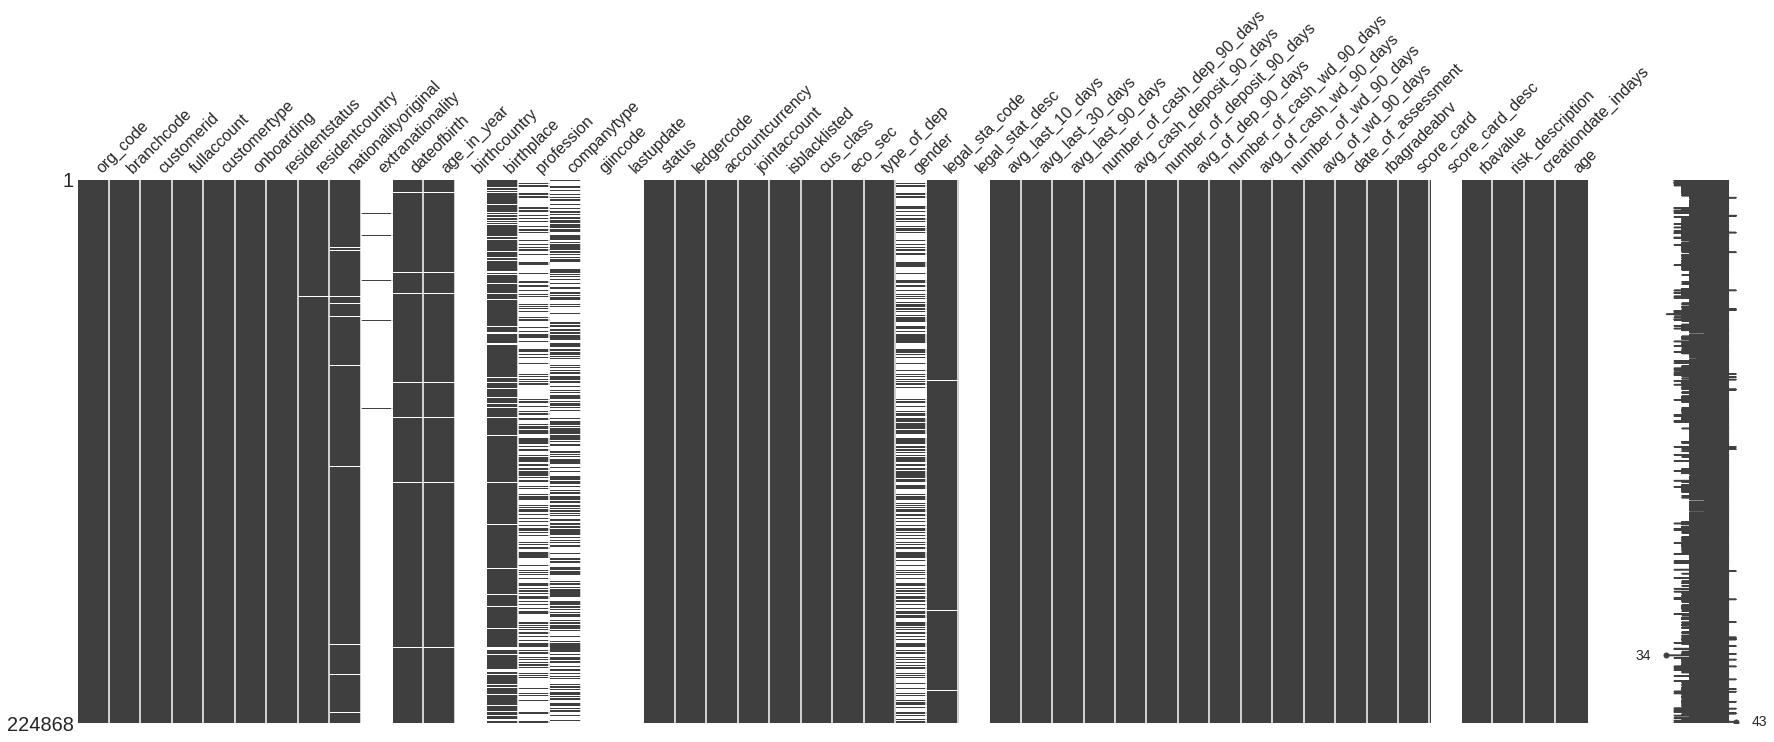

In [169]:
import missingno
missingno.matrix(df, figsize = (30,10))

## Define a function to check for % of missing values by Column

In [170]:
def plot_nulls(data_frame):
  """find nulls for every column and plot only those which are true. 
     plot shows % of Non-Null values per column"""
  nulls = {}

  for col in data_frame.columns:
      nulls[col] = (1-(len(data_frame[data_frame[col].isna()][col]) / data_frame.shape[0]))

  labels = []
  vals = []

  for k, v in nulls.items():
      if v < 1.0:
          labels.append(k)
          vals.append(v*100)

  _, ax = plt.subplots(figsize=(12,5))

  sns.barplot(y=vals, x=labels, color='lightskyblue')
  ax.set_xticklabels(labels=labels, rotation=45)
  plt.title('% Non-Null (clean) Values by Columns')
  ax.set_xlabel('columns')
  ax.set_ylabel('%')
  plt.show()

  print(f'columns with nulls: {labels}')

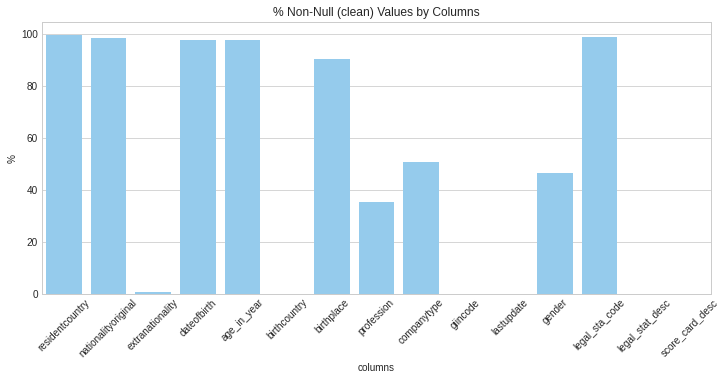

columns with nulls: ['residentcountry', 'nationalityoriginal', 'extranationality', 'dateofbirth', 'age_in_year', 'birthcountry', 'birthplace', 'profession', 'companytype', 'giincode', 'lastupdate', 'gender', 'legal_sta_code', 'legal_stat_desc', 'score_card_desc']


In [171]:
plot_nulls(df)

## On out 1st step we will treat nulls in the following way:
#### - Drop cols with more than 90% NAs 
####### -----(Imputting values for columns with such huge missing values could make our model unreliable)
#### - We will use columns_to_drop list to append every column that we need to delete as we continue the analysis
#### ----------------------------------------------------
#### We will consider the following options for null treatment:
###### ------ Dropping rows/cols
###### ------ Imputting with IterativeImputer  (using other independent variables to predict nulls/missing values)
###### ------ Imputting mean/median/mode


### Imputting values for columns with such huge missing values as the ones below could affect our model outcome and therefore will be removed

In [172]:
# after first run of nulls detection
columns_to_drop = ['extranationality','birthcountry','giincode','lastupdate','legal_stat_desc','score_card_desc','rbagradeabrv']



## Before we move on, we see there are two types of customers: 
## - companies
## - individuals.

## Let's have a look...



In [173]:
df.customertype.value_counts()

1    199139
2     25729
Name: customertype, dtype: int64

In [174]:
df_companies = df[df.customertype==2]
df_companies.head()


,org_code,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,extranationality,dateofbirth,age_in_year,birthcountry,birthplace,profession,companytype,giincode,lastupdate,status,ledgercode,accountcurrency,jointaccount,isblacklisted,cus_class,eco_sec,type_of_dep,gender,legal_sta_code,legal_stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,date_of_assessment,rbagradeabrv,score_card,score_card_desc,rbavalue,risk_description,creationdate_indays,age
0,1,201,20100400550000072,020100400550015817000,2,N,1,JO,JO,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,Active,5817,JOD,0,0,4,46,35,NaN,2.0,NaN,8610000.00,2170000.00,23333.33,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,E-Existing,NaN,13.2,Low,1295,0
10,1,202,20200217770000674,020200217770012964000,2,N,1,JO,JO,NaN,1976-04-04,43.0,NaN,????,NaN,NaN,NaN,NaN,Active,2964,JOD,0,0,2,90,20,NaN,1.0,NaN,2569.65,647.24,7.16,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,E-Existing,NaN,13.2,Low,1844,42
11,1,202,20200217770000674,020200217770011400000,2,N,1,JO,JO,NaN,1976-04-04,43.0,NaN,????,NaN,NaN,NaN,NaN,Active,1400,JOD,0,0,2,90,20,NaN,1.0,NaN,-4210.93,-1060.71,-11.45,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,E-Existing,NaN,13.2,Low,1844,42
12,1,202,20200217770000674,020200217770011413000,2,N,1,JO,JO,NaN,1976-04-04,43.0,NaN,????,NaN,NaN,NaN,NaN,Active,1413,JOD,0,0,2,90,20,NaN,1.0,NaN,-11720.09,-2951.93,-31.89,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,E-Existing,NaN,13.2,Low,1844,42
13,1,202,20200217770000674,020200217770011924030,2,N,1,JO,JO,NaN,1976-04-04,43.0,NaN,????,NaN,NaN,NaN,NaN,Active,1924,JOD,0,0,2,90,20,NaN,1.0,NaN,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,E-Existing,NaN,13.2,Low,1844,42


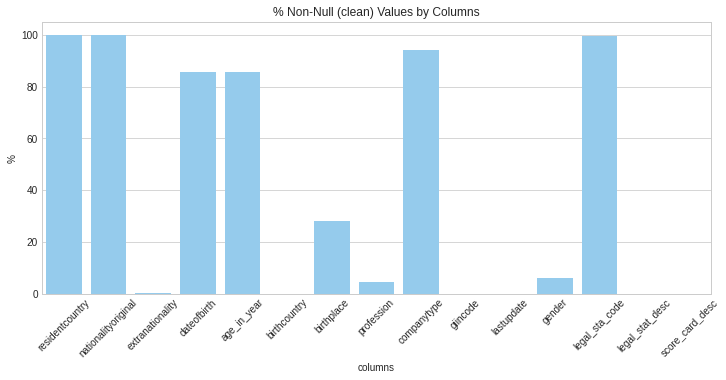

columns with nulls: ['residentcountry', 'nationalityoriginal', 'extranationality', 'dateofbirth', 'age_in_year', 'birthcountry', 'birthplace', 'profession', 'companytype', 'giincode', 'lastupdate', 'gender', 'legal_sta_code', 'legal_stat_desc', 'score_card_desc']


In [175]:
plot_nulls(df_companies)

### Companies with birthplace, profession and gender? Doesn't seem right... remove..

In [176]:
df_individuals = df[df.customertype==1]
df_individuals.head()

,org_code,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,extranationality,dateofbirth,age_in_year,birthcountry,birthplace,profession,companytype,giincode,lastupdate,status,ledgercode,accountcurrency,jointaccount,isblacklisted,cus_class,eco_sec,type_of_dep,gender,legal_sta_code,legal_stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,date_of_assessment,rbagradeabrv,score_card,score_card_desc,rbavalue,risk_description,creationdate_indays,age
1,1,202,20200207860000638,020200207860011330000,1,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,1330,JOD,0,0,2,90,23,2.0,1.0,NaN,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,I-Existing,NaN,16.93,Low,1860,29
2,1,202,20200207860000638,020200207860011389002,1,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,1389,JOD,0,0,2,90,23,2.0,1.0,NaN,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,I-Existing,NaN,16.93,Low,1860,29
3,1,202,20200207860000638,020200207860010060000,1,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,60,JOD,0,0,2,90,23,2.0,1.0,NaN,2079.79,526.87,6.68,4,-550.0,4,-550.0,1,50.0,1,50.0,2019-01-24,L,I-Existing,NaN,16.93,Low,1860,29
4,1,202,20200207860000638,020200207860010010000,1,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,10,JOD,0,0,2,90,23,2.0,1.0,NaN,444.00,120.50,0.95,4,-540.0,4,-540.0,1,56.0,1,56.0,2019-01-24,L,I-Existing,NaN,16.93,Low,1860,29
5,1,202,20200207860000638,020200207860011355003,1,N,1,JO,JO,NaN,1989-06-30,30.0,NaN,????,27.0,NaN,NaN,NaN,Active,1355,JOD,0,0,2,90,23,2.0,1.0,NaN,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,2019-01-24,L,I-Existing,NaN,16.93,Low,1860,29


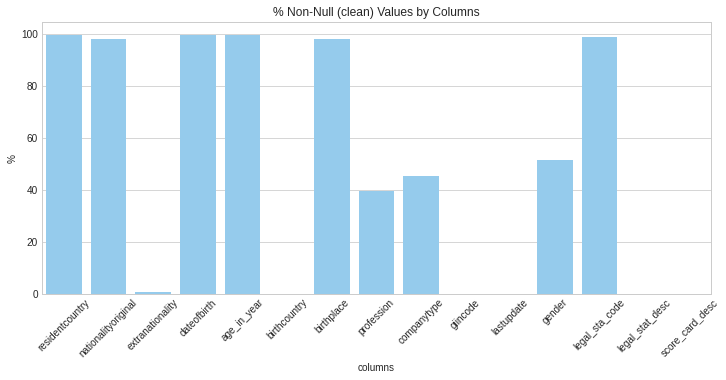

columns with nulls: ['residentcountry', 'nationalityoriginal', 'extranationality', 'dateofbirth', 'age_in_year', 'birthcountry', 'birthplace', 'profession', 'companytype', 'giincode', 'lastupdate', 'gender', 'legal_sta_code', 'legal_stat_desc', 'score_card_desc']


In [177]:
plot_nulls(df_individuals)

In [178]:
df_companies.describe()

,org_code,branchcode,customerid,customertype,residentstatus,age_in_year,birthcountry,profession,companytype,lastupdate,ledgercode,jointaccount,isblacklisted,cus_class,eco_sec,type_of_dep,gender,legal_sta_code,legal_stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,score_card_desc,rbavalue,creationdate_indays,age
count,25729.0,25729.000000,2.572900e+04,25729.0,25729.000000,22041.000000,0.0,1145.000000,24250.000000,0.0,25729.000000,25729.000000,25729.0,25729.000000,25729.000000,25729.000000,1554.000000,25573.000000,0.0,2.572900e+04,2.572900e+04,25729.000000,25729.000000,2.572900e+04,25729.000000,2.572900e+04,25729.000000,2.572900e+04,25729.000000,2.572900e+04,0.0,25729.000000,25729.000000,25729.000000
mean,1.0,340.531035,3.334839e+16,2.0,1.003304,22.493172,NaN,20.405240,46.333402,NaN,1478.129970,0.026973,0.0,4.142369,89.020599,44.994481,1.097169,2.453486,NaN,-3.696291e+04,-9.234523e+03,-113.498080,1.133585,-4.508328e+03,4.642388,-2.047993e+04,0.146760,1.264838e+03,3.150181,1.240293e+04,NaN,22.274281,3329.704380,18.461075
std,0.0,186.983936,1.935207e+16,0.0,0.057384,15.971042,NaN,6.579793,13.454584,NaN,1336.402037,0.162009,0.0,2.490572,84.977064,14.345217,0.296283,0.585953,NaN,3.205985e+06,8.108442e+05,9017.169524,13.426465,7.550429e+04,55.330226,2.539362e+05,1.431802,5.740095e+04,33.610718,1.618758e+05,NaN,10.509338,2682.070339,16.626923
min,1.0,201.000000,2.020081e+09,2.0,1.000000,1.000000,NaN,1.000000,1.000000,NaN,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,NaN,-1.435937e+08,-3.616234e+07,-390970.590000,0.000000,-4.641217e+06,0.000000,-1.654371e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,7.200000,0.000000,0.000000
25%,1.0,206.000000,2.060023e+16,2.0,1.000000,11.000000,NaN,14.000000,37.000000,NaN,60.000000,0.000000,0.0,4.000000,40.000000,37.000000,1.000000,2.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,15.200000,1390.000000,5.000000
50%,1.0,208.000000,2.080231e+16,2.0,1.000000,20.000000,NaN,25.000000,52.000000,NaN,1344.000000,0.000000,0.0,4.000000,56.000000,52.000000,1.000000,2.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,19.200000,2411.000000,14.000000
75%,1.0,402.000000,4.021229e+16,2.0,1.000000,27.000000,NaN,25.000000,54.000000,NaN,1393.000000,0.000000,0.0,4.000000,90.000000,54.000000,1.000000,3.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,25.200000,4597.000000,26.000000
max,1.0,805.000000,8.052727e+16,2.0,2.000000,90.000000,NaN,27.000000,100.000000,NaN,5817.000000,1.000000,0.0,15.000000,392.000000,100.000000,2.000000,4.000000,NaN,1.531514e+08,3.859913e+07,415044.440000,1267.000000,0.000000e+00,3292.000000,5.867291e+05,58.000000,8.394000e+06,2858.000000,9.942530e+06,NaN,65.600000,14053.000000,90.000000


In [179]:
df_individuals.describe()

,org_code,branchcode,customerid,customertype,residentstatus,age_in_year,birthcountry,profession,companytype,lastupdate,ledgercode,jointaccount,isblacklisted,cus_class,eco_sec,type_of_dep,gender,legal_sta_code,legal_stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,score_card_desc,rbavalue,creationdate_indays,age
count,199139.0,199139.000000,1.991390e+05,199139.0,199139.000000,198112.000000,0.0,78603.000000,90324.000000,0.0,199139.000000,199139.000000,199139.0,199139.000000,199139.000000,199139.000000,102803.000000,196679.000000,0.0,1.991390e+05,1.991390e+05,199139.000000,199139.000000,1.991390e+05,199139.000000,1.991390e+05,199139.000000,1.991390e+05,199139.000000,1.991390e+05,0.0,199139.000000,199139.000000,199139.000000
mean,1.0,462.394754,4.531413e+16,1.0,1.023536,43.404110,NaN,18.278959,50.803740,NaN,1005.219133,0.020965,0.0,3.716505,89.436183,34.283480,1.253300,1.029744,NaN,1.361985e+04,3.439036e+03,35.973676,0.408453,-6.748107e+02,0.677818,-1.351773e+03,0.268200,3.745160e+02,0.573725,1.165145e+03,NaN,17.023397,2301.397973,42.314715
std,0.0,229.311347,2.363207e+16,0.0,0.151600,14.572075,NaN,6.581690,2.174383,NaN,1263.441517,0.143268,0.0,4.483917,6.597614,15.208292,0.434903,0.193341,NaN,8.090610e+05,2.033083e+05,2196.943775,2.965133,1.723887e+04,6.443403,3.292920e+04,1.137546,6.220068e+03,5.117408,2.060930e+04,NaN,7.851948,2347.295074,14.944284
min,1.0,201.000000,2.020028e+09,1.0,1.000000,1.000000,NaN,1.000000,1.000000,NaN,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,NaN,-1.791005e+08,-4.513426e+07,-485686.730000,0.000000,-5.482044e+06,0.000000,-8.200000e+06,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,4.080000,0.000000,0.000000
25%,1.0,208.000000,2.080033e+16,1.0,1.000000,33.000000,NaN,20.000000,51.000000,NaN,20.000000,0.000000,0.0,2.000000,90.000000,20.000000,1.000000,1.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,13.280000,684.000000,32.000000
50%,1.0,402.000000,4.021227e+16,1.0,1.000000,42.000000,NaN,20.000000,51.000000,NaN,60.000000,0.000000,0.0,2.000000,90.000000,23.000000,1.000000,1.000000,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,16.530000,1676.000000,41.000000
75%,1.0,702.000000,7.020072e+16,1.0,1.000000,53.000000,NaN,21.000000,51.000000,NaN,1396.000000,0.000000,0.0,2.000000,90.000000,51.000000,2.000000,1.000000,NaN,7.649550e+02,2.017700e+02,1.530000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,20.500000,2852.000000,52.000000
max,1.0,805.000000,8.052929e+16,1.0,2.000000,119.000000,NaN,39.000000,60.000000,NaN,8700.000000,1.000000,0.0,51.000000,353.000000,99.000000,2.000000,4.000000,NaN,8.200000e+07,2.066667e+07,222222.220000,243.000000,0.000000e+00,1299.000000,5.645933e+05,78.000000,1.119818e+06,634.000000,2.662953e+06,NaN,100.000000,14644.000000,118.000000


### We observe that for individuals at least half of the data for profession and gender is missing and therefore we will remove these columns

In [180]:
columns_to_drop.append('profession')
columns_to_drop.append('gender')
columns_to_drop

['extranationality',
 'birthcountry',
 'giincode',
 'lastupdate',
 'legal_stat_desc',
 'score_card_desc',
 'rbagradeabrv',
 'profession',
 'gender']

### For individuals, 'companytype' is null. We will replace by 0  

### For companies, we will input the mode

In [181]:
df['companytype'].unique()

array([ 35.,  nan,  51.,   2.,  49.,   1.,  37.,  54.,   5.,  36.,  13.,
        52.,  57.,  14.,  17.,  53.,  10.,  11.,  15.,  58.,  56.,  16.,
        50.,  64.,  12., 100.,   4.,  55.,   6.,  61.,  60.,   7.,   3.,
        46.])

In [182]:
df_individuals = df[df.customertype==1]
df_companies = df[df.customertype==2]

In [183]:
df_companies.companytype.mode()[0]

54.0

In [184]:
df_individuals['companytype'] = df_individuals['companytype'].fillna(0)
df_companies['companytype'] = df_companies['companytype'].fillna(54)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
dfs = [df_individuals,df_companies]
df = pd.concat(dfs)

In [186]:
df_companies.companytype.isna().value_counts()

False    25729
Name: companytype, dtype: int64

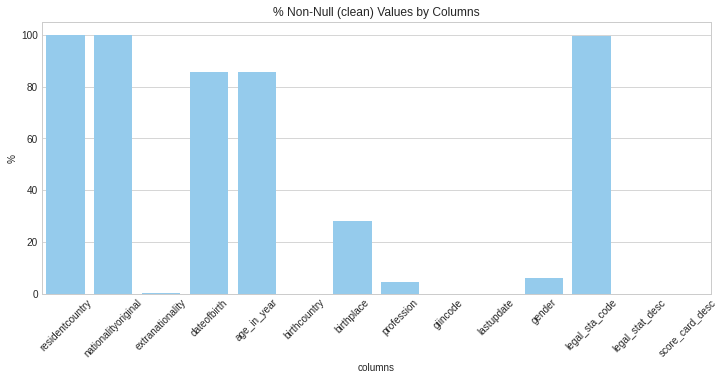

columns with nulls: ['residentcountry', 'nationalityoriginal', 'extranationality', 'dateofbirth', 'age_in_year', 'birthcountry', 'birthplace', 'profession', 'giincode', 'lastupdate', 'gender', 'legal_sta_code', 'legal_stat_desc', 'score_card_desc']


In [187]:
plot_nulls(df_companies)

### Let's look at some columns in isolation

##### BirthPlace: We replaced all the '?','??' for NAs... unfortunately we need to remove birthPlace due to containing 90% of them after the transformation

In [188]:
df['birthplace'] = df['birthplace'].str.replace("\?+", "?")
df['birthplace'].replace({'?': None},inplace =True)

df['birthplace'].isna().value_counts()
columns_to_drop.append('birthplace')

### Cast date columns to datetime format

### Check if columns have only one unique value  >>> in these cases we drop the columns

In [189]:

for col in df.columns:
    """check if there is only one constant value on the variable, therefefore drop"""
    if len(df[col].unique()) == 1:
        print (f'we are dropping: {col}')
        columns_to_drop.append(col)

we are dropping: org_code
we are dropping: birthcountry
we are dropping: lastupdate
we are dropping: status
we are dropping: isblacklisted
we are dropping: legal_stat_desc
we are dropping: date_of_assessment
we are dropping: score_card_desc


In [190]:
columns_to_drop

['extranationality',
 'birthcountry',
 'giincode',
 'lastupdate',
 'legal_stat_desc',
 'score_card_desc',
 'rbagradeabrv',
 'profession',
 'gender',
 'birthplace',
 'org_code',
 'birthcountry',
 'lastupdate',
 'status',
 'isblacklisted',
 'legal_stat_desc',
 'date_of_assessment',
 'score_card_desc']

## We proceed to delete columns 
#### we check that none of our columns are double counted (that they satisfy more than one filter)

In [191]:
auxiliary_drop_list = []
for word in columns_to_drop:
    if word not in auxiliary_drop_list:
        auxiliary_drop_list.append(word)

In [192]:
## columns to be dropped
auxiliary_drop_list

['extranationality',
 'birthcountry',
 'giincode',
 'lastupdate',
 'legal_stat_desc',
 'score_card_desc',
 'rbagradeabrv',
 'profession',
 'gender',
 'birthplace',
 'org_code',
 'status',
 'isblacklisted',
 'date_of_assessment']

In [193]:
df = df.drop(columns=auxiliary_drop_list)

In [194]:
df.head()

,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,dateofbirth,age_in_year,companytype,ledgercode,accountcurrency,jointaccount,cus_class,eco_sec,type_of_dep,legal_sta_code,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,score_card,rbavalue,risk_description,creationdate_indays,age
1,202,20200207860000638,020200207860011330000,1,N,1,JO,JO,1989-06-30,30.0,0.0,1330,JOD,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,I-Existing,16.93,Low,1860,29
2,202,20200207860000638,020200207860011389002,1,N,1,JO,JO,1989-06-30,30.0,0.0,1389,JOD,0,2,90,23,1.0,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,I-Existing,16.93,Low,1860,29
3,202,20200207860000638,020200207860010060000,1,N,1,JO,JO,1989-06-30,30.0,0.0,60,JOD,0,2,90,23,1.0,2079.79,526.87,6.68,4,-550.0,4,-550.0,1,50.0,1,50.0,I-Existing,16.93,Low,1860,29
4,202,20200207860000638,020200207860010010000,1,N,1,JO,JO,1989-06-30,30.0,0.0,10,JOD,0,2,90,23,1.0,444.00,120.50,0.95,4,-540.0,4,-540.0,1,56.0,1,56.0,I-Existing,16.93,Low,1860,29
5,202,20200207860000638,020200207860011355003,1,N,1,JO,JO,1989-06-30,30.0,0.0,1355,JOD,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,I-Existing,16.93,Low,1860,29


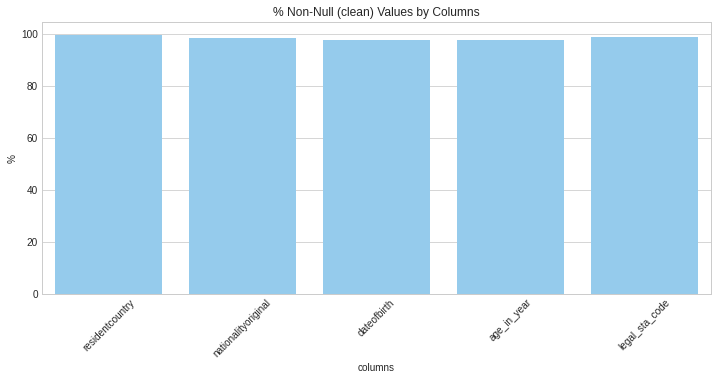

columns with nulls: ['residentcountry', 'nationalityoriginal', 'dateofbirth', 'age_in_year', 'legal_sta_code']


In [195]:
plot_nulls(df)

### We will input the mode for the categorical columns 
### For 'dateofbirth' & 'age_in_year' we have calculated 'age', so we will remove those two columns, and input the non-zero average for the 0s we got when calculating 'age' column

In [196]:
more_to_remove = ['dateofbirth', 'age_in_year']
df = df.drop(columns=more_to_remove)

In [197]:
mean_age = df.age[df.age != 0].mean()
mean_age

40.44957376036062

In [198]:
df.age = df.age.replace(0,mean_age)
#df['a']=df['a'].replace(0,df['a'].mean())

In [199]:
df.age[df.age == mean_age]

32        40.449574
33        40.449574
34        40.449574
35        40.449574
36        40.449574
            ...    
224506    40.449574
224556    40.449574
224649    40.449574
224680    40.449574
224829    40.449574
Name: age, Length: 4804, dtype: float64

#### Input mode for categorical values

In [200]:
for column in ['residentcountry', 'nationalityoriginal', 'legal_sta_code']:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [201]:
df.age = df.age.replace(0,mean_age)
#df['a']=df['a'].replace(0,df['a'].mean())

## 4.3 Further Error Analysis
#### After removing nulls, it is important to check that the remaining values are contained in the metadata, otherwise this is telling us they are probably wrong data inputs

In [202]:
metadata_cols = list(metadata_full_table.sheet.unique())
metadata_cols.remove('profession')
metadata_cols

['companytype',
 'ledgercode',
 'cus_class',
 'eco_sec',
 'type_of_dep',
 'legal_sta_code',
 'residentcountry',
 'accountcurrency']

In [203]:
in_metadata = []
not_in_metadata = []

def check_metadata(data_frame):
    for col in metadata_cols:
      if  all(data_frame[col].isin(metadata_full_table.loc[metadata_full_table['sheet'] == col, 'value'])):
        in_metadata.append(col)
      else:
        not_in_metadata.append(col)
    print(f'All values from these cols are in meta data:\n{in_metadata}\n\nNot all values from these cols are in metadata and therefore we could remove them:\n{not_in_metadata}')

In [204]:
check_metadata(df)

All values from these cols are in meta data:
['cus_class', 'eco_sec', 'type_of_dep', 'legal_sta_code', 'accountcurrency']

Not all values from these cols are in metadata and therefore we could remove them:
['companytype', 'ledgercode', 'residentcountry']


#### We have also deep dived in customerid column. 

#### we see that some ids have less than 17 digits (the norm), which indicates they might be wrong

In [205]:
df_trial = df.copy()

In [206]:
df_trial['customerid'] = df_trial['customerid'].apply(str)

In [207]:
df_trial.value_counts()

branchcode  customerid         fullaccount            customertype  onboarding  residentstatus  residentcountry  nationalityoriginal  companytype  ledgercode  accountcurrency  jointaccount  cus_class  eco_sec  type_of_dep  legal_sta_code  avg_last_10_days  avg_last_30_days  avg_last_90_days  number_of_cash_dep_90_days  avg_cash_deposit_90_days  number_of_deposit_90_days  avg_of_dep_90_days  number_of_cash_wd_90_days  avg_of_cash_wd_90_days  number_of_wd_90_days  avg_of_wd_90_days  score_card  rbavalue  risk_description  creationdate_indays  age      
805         80529290000003846  080529290000012806000  1             N           1               JO               JO                   0.0          2806        JOD              0             2          90       20           1.0              323032.63         77887.50          404.04           0                            0.0                      0                           0.0                0                          0.0                   

#### 2.27% of the dataset has customerid with less than 17 digits!

In [208]:
a = (df_trial['customerid'].str.len() <17)
df_trial = df_trial.loc[a]
df_trial['customerid']

212       2020049731
213       2020049731
214       2020049731
215       2020049731
216       2020049731
             ...    
221096    3510093053
221294    2050070828
222795    3510093053
224098    2050070828
224250    3510093053
Name: customerid, Length: 4920, dtype: object

In [209]:
## we have 133 unique ids with less than 17 digits
df_trial['customerid'].nunique()

1344

## 4.4 We will now make some plots

#### We want to classify each column to better do feature selection / engineering

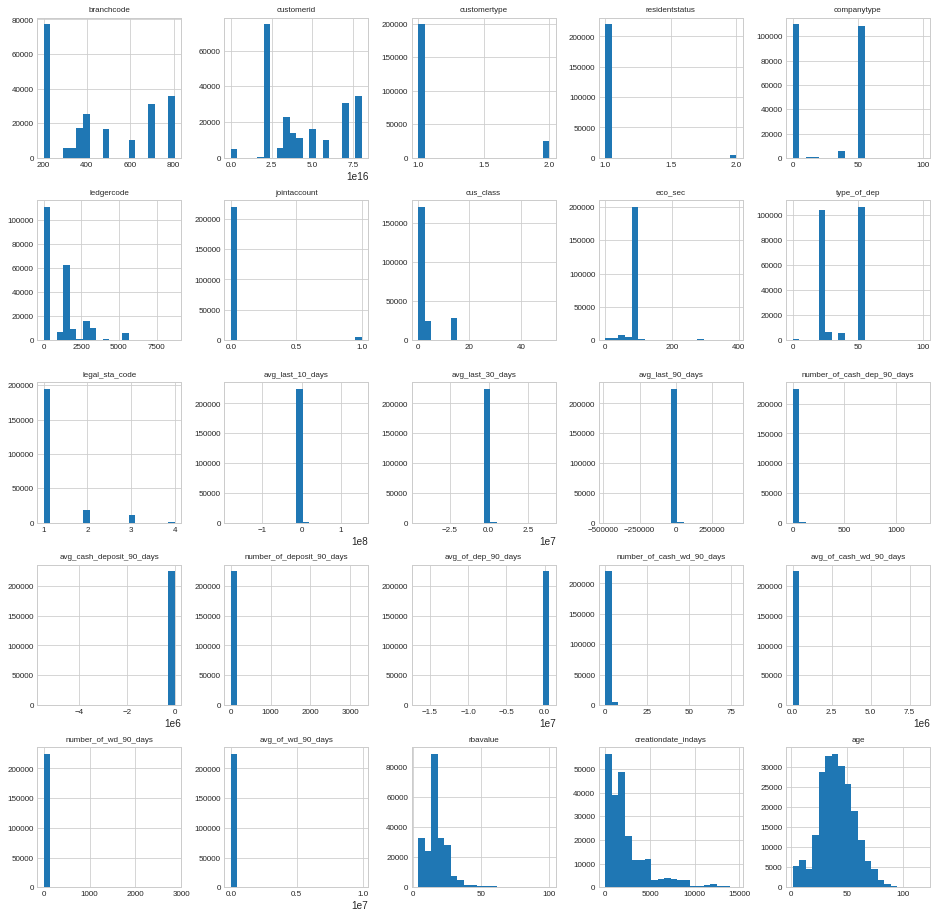

In [210]:
%matplotlib inline
import matplotlib.pylab as plt
attribute_columns = list(df.columns)
if True:
    fontsize = 8
    fig = df[attribute_columns].hist(bins = 20, figsize = (16, 16),
                                       xlabelsize=fontsize,
                                       ylabelsize=fontsize)
    for x in fig.ravel():
        x.title.set_size(fontsize)
else:
    nrows = (len(attribute_columns)+1) // 2
    plt.figure(figsize=(12,25))
    for i in range(len(attribute_columns)):
        name = attribute_columns[i]
        plt.subplot(nrows,2,i+1)
        data[name].hist()
        plt.title(name, fontsize=14)
    
plt.show()

## We will split columns according to their data type

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224868 entries, 1 to 224864
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   branchcode                  224868 non-null  int64  
 1   customerid                  224868 non-null  int64  
 2   fullaccount                 224868 non-null  object 
 3   customertype                224868 non-null  int64  
 4   onboarding                  224868 non-null  object 
 5   residentstatus              224868 non-null  int64  
 6   residentcountry             224868 non-null  object 
 7   nationalityoriginal         224868 non-null  object 
 8   companytype                 224868 non-null  float64
 9   ledgercode                  224868 non-null  int64  
 10  accountcurrency             224868 non-null  object 
 11  jointaccount                224868 non-null  int64  
 12  cus_class                   224868 non-null  int64  
 13  eco_sec       

In [212]:
rows, cols = df.shape
print(f'Current Dataset\n-------\ncolumns: {cols}\nrows: {rows}')
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['float64','int64']).columns
print(f'categorical columns: {len(cat_cols)}\nnumeric columns: {len(num_cols)}')
cat_cols = list(df[cat_cols])
num_cols = list(df[num_cols])
print('\n\n=================\n')
print(f'categorical columns: {cat_cols}\n\n=================\n')
print(f'numeric columns: {num_cols}\n\n=================\n')


Current Dataset
-------
columns: 32
rows: 224868
categorical columns: 7
numeric columns: 25



categorical columns: ['fullaccount', 'onboarding', 'residentcountry', 'nationalityoriginal', 'accountcurrency', 'score_card', 'risk_description']


numeric columns: ['branchcode', 'customerid', 'customertype', 'residentstatus', 'companytype', 'ledgercode', 'jointaccount', 'cus_class', 'eco_sec', 'type_of_dep', 'legal_sta_code', 'avg_last_10_days', 'avg_last_30_days', 'avg_last_90_days', 'number_of_cash_dep_90_days', 'avg_cash_deposit_90_days', 'number_of_deposit_90_days', 'avg_of_dep_90_days', 'number_of_cash_wd_90_days', 'avg_of_cash_wd_90_days', 'number_of_wd_90_days', 'avg_of_wd_90_days', 'rbavalue', 'creationdate_indays', 'age']




In [213]:
discrete_cols = ['score_card']



### We now have 2 types of cols

####cat_cols (with discrete cols within)
####num_cols 



#### We plot the categorical variables

In [214]:
cat_cols

['fullaccount',
 'onboarding',
 'residentcountry',
 'nationalityoriginal',
 'accountcurrency',
 'score_card',
 'risk_description']

In [215]:
cat_cols_plotting = cat_cols 
cat_cols_plotting.remove('fullaccount')
cat_cols_plotting

['onboarding',
 'residentcountry',
 'nationalityoriginal',
 'accountcurrency',
 'score_card',
 'risk_description']

In [216]:
df_cat_plotting = df[cat_cols_plotting]

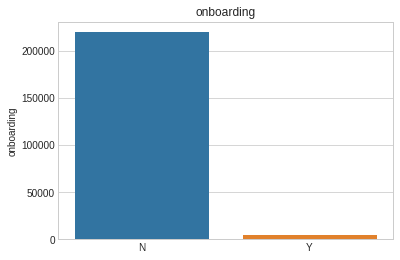

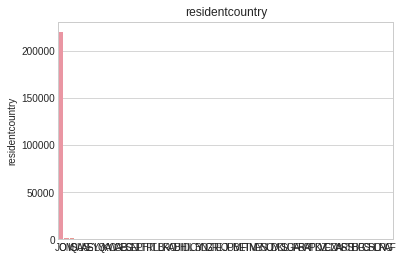

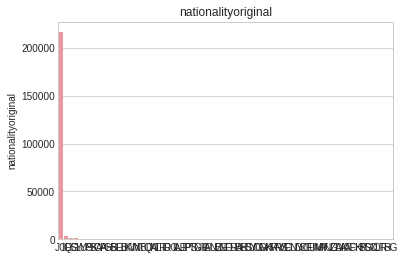

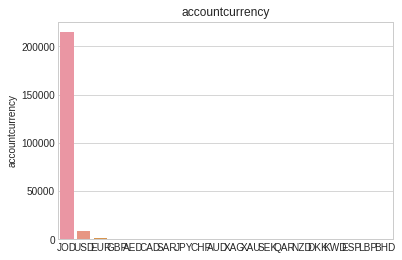

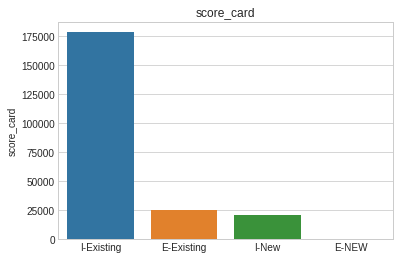

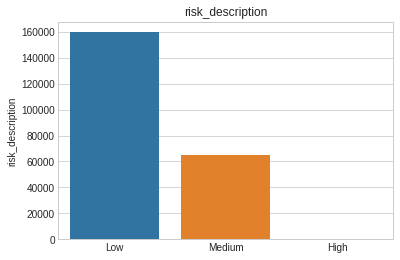

In [217]:
for i in df_cat_plotting.columns:
  sns.barplot(x=df_cat_plotting[i].value_counts().index,y=df_cat_plotting[i].value_counts()).set_title(i)
  plt.show()

## 4.3 Outliers

In [218]:
cont_cols = ['age','creationdate_indays']

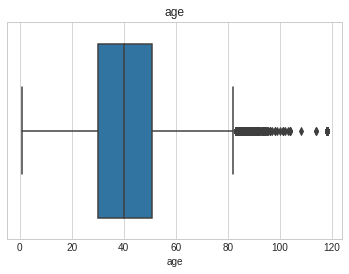

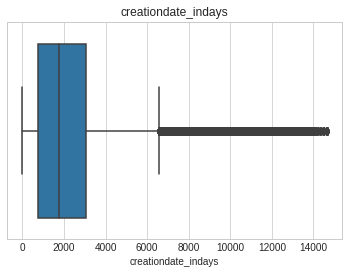

In [219]:
for x in cont_cols:
    sns.boxplot(x=df[x])
    plt.title(x)
    plt.show()

#### We believe it is not neccessary in our case to remove outliers

# 5. Feature engineering
## 5.1 Checking skewness of variables

#### 'risk_description' is our classification target variable >>>> we assign 0s and 1s

In [220]:
df.risk_description[df.risk_description == 'Low'] = 0
df.risk_description[df.risk_description == 'Medium'] = 1 
df.risk_description[df.risk_description == 'High'] = 1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

#### 'rbavalue' is our Regression target variable

In [221]:
X = df.loc[:, df.columns != 'rbavalue']
y = df.loc[:, df.columns == 'rbavalue']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


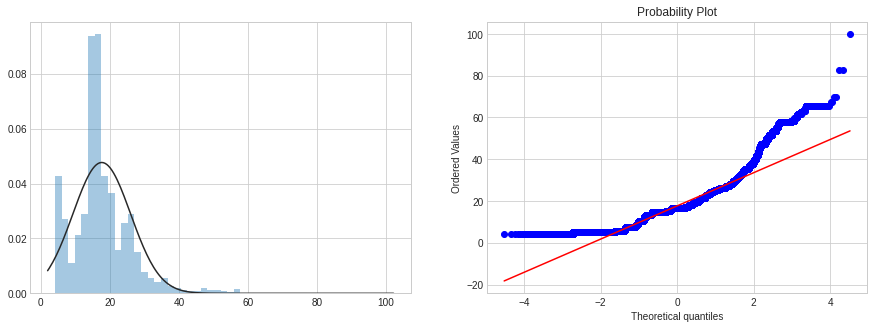

Fisher-Pearson coeficient of skewness: 1.38


In [222]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.distplot(y, fit=stats.norm, ax=ax[0], kde=False)
stats.probplot(y.rbavalue,  plot=ax[1])
plt.show()
print(f'Fisher-Pearson coeficient of skewness: {stats.skew(y.rbavalue.values):.2f}')

#####Less than −1 or greater than + 1, the distribution is strongly skewed.
#####If skewness is between −1 and −½ or between + ½ and +1, the distribution is moderately asymmetric
#####If skewness is between − ½ and + ½, the distributions approximately symmetric

In [223]:
lmbda = 0.0
y = y.apply(lambda x: stats.boxcox(1+x, lmbda=lmbda))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


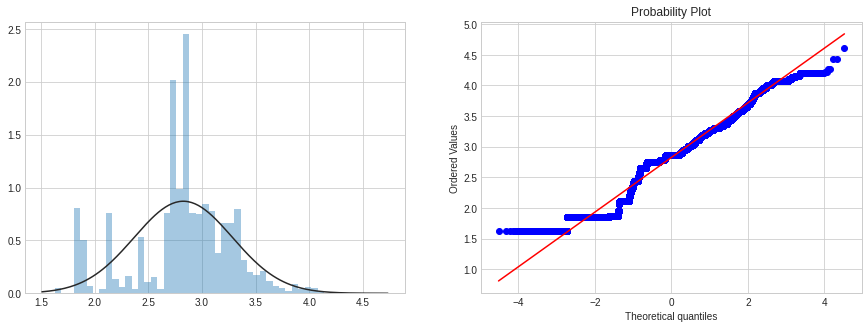

Fisher-Pearson coeficient of skewness: -0.42


In [224]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.distplot(y, fit=stats.norm, ax=ax[0], kde=False)
stats.probplot(y.rbavalue,  plot=ax[1])
plt.show()
print(f'Fisher-Pearson coeficient of skewness: {stats.skew(y.rbavalue.values):,.2f}')

#### We transformed the y variable and is now approximately symmetric

## 5.2 Correlation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


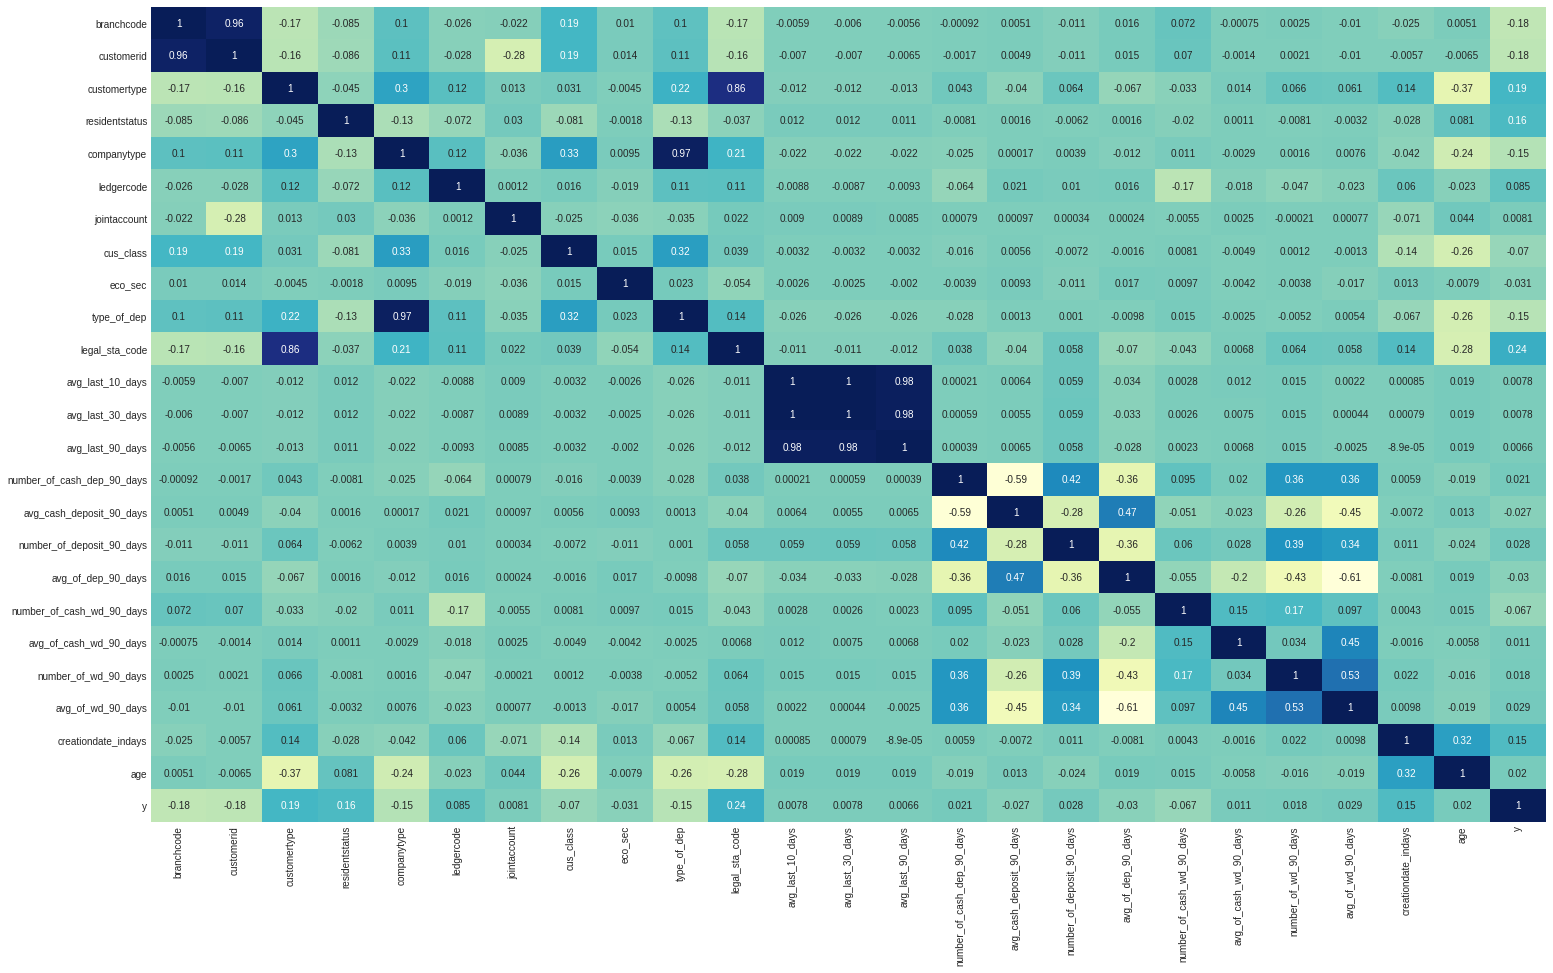

In [225]:
X_num = X.loc[:,X.columns.isin(num_cols)]

X_num['y'] = y

_, ax = plt.subplots(figsize=(25,15))

sns.heatmap(X_num.corr(), annot=True, cbar=False, cmap='YlGnBu')
plt.show()


#### Filter variables where correlation with target variable is higher than 0.1

In [226]:
mask = (abs(X_num.corr()['y'] >= 0.1))
corr_variables = X_num.corr()['y'][mask]
corr_variables = list(corr_variables[corr_variables.index != 'y'].index)

corr_variables

['customertype', 'residentstatus', 'legal_sta_code', 'creationdate_indays']

## 5.3 One hot encoding for discrete variables and test for correlation

In [227]:
discrete_cols

['score_card']

In [228]:
df_encoded = pd.get_dummies(df[discrete_cols],drop_first=True)

In [229]:
discrete_todelete = ['score_card']
df = df.drop(columns=discrete_todelete)

In [230]:
df = pd.concat([df, df_encoded], axis=1)

In [231]:
df.head()

,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,companytype,ledgercode,accountcurrency,jointaccount,cus_class,eco_sec,type_of_dep,legal_sta_code,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,rbavalue,risk_description,creationdate_indays,age,score_card_E-NEW,score_card_I-Existing,score_card_I-New
1,202,20200207860000638,020200207860011330000,1,N,1,JO,JO,0.0,1330,JOD,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0
2,202,20200207860000638,020200207860011389002,1,N,1,JO,JO,0.0,1389,JOD,0,2,90,23,1.0,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0
3,202,20200207860000638,020200207860010060000,1,N,1,JO,JO,0.0,60,JOD,0,2,90,23,1.0,2079.79,526.87,6.68,4,-550.0,4,-550.0,1,50.0,1,50.0,16.93,0,1860,29.0,0,1,0
4,202,20200207860000638,020200207860010010000,1,N,1,JO,JO,0.0,10,JOD,0,2,90,23,1.0,444.00,120.50,0.95,4,-540.0,4,-540.0,1,56.0,1,56.0,16.93,0,1860,29.0,0,1,0
5,202,20200207860000638,020200207860011355003,1,N,1,JO,JO,0.0,1355,JOD,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0


In [232]:
# we need to lower the new cols
df.columns = df.columns.str.lower()

In [233]:
encoded_cols = ['score_card_e-new',
       'score_card_i-existing', 'score_card_i-new']

In [234]:
X_2 = df.loc[:, df.columns != 'rbavalue']
y_2 = df.loc[:, df.columns == 'rbavalue']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


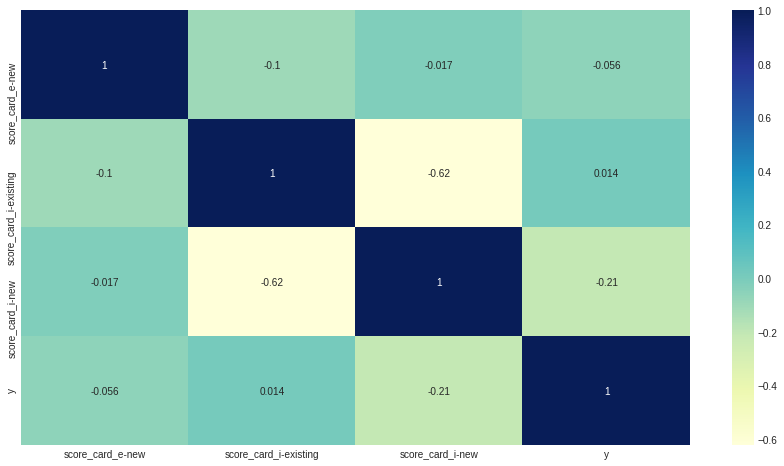

In [235]:
X_discrete = X_2.loc[:, X_2.columns.isin(encoded_cols)]
X_discrete['y'] = y_2

_, ax = plt.subplots(figsize=(15,8))

sns.heatmap(X_discrete.corr('spearman'), annot=True, cmap='YlGnBu')
plt.show()

#### Filter variables where correlation with target variable is higher than 0.1

In [236]:
mask = (abs(X_discrete.corr()['y'] >= 0.1))
corr_variables = X_discrete.corr()['y'][mask]
corr_variables = list(corr_variables[corr_variables.index != 'y'].index)

corr_variables

[]

In [237]:
df.head()

,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,companytype,ledgercode,accountcurrency,jointaccount,cus_class,eco_sec,type_of_dep,legal_sta_code,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,rbavalue,risk_description,creationdate_indays,age,score_card_e-new,score_card_i-existing,score_card_i-new
1,202,20200207860000638,020200207860011330000,1,N,1,JO,JO,0.0,1330,JOD,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0
2,202,20200207860000638,020200207860011389002,1,N,1,JO,JO,0.0,1389,JOD,0,2,90,23,1.0,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0
3,202,20200207860000638,020200207860010060000,1,N,1,JO,JO,0.0,60,JOD,0,2,90,23,1.0,2079.79,526.87,6.68,4,-550.0,4,-550.0,1,50.0,1,50.0,16.93,0,1860,29.0,0,1,0
4,202,20200207860000638,020200207860010010000,1,N,1,JO,JO,0.0,10,JOD,0,2,90,23,1.0,444.00,120.50,0.95,4,-540.0,4,-540.0,1,56.0,1,56.0,16.93,0,1860,29.0,0,1,0
5,202,20200207860000638,020200207860011355003,1,N,1,JO,JO,0.0,1355,JOD,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0


## 5.4 Data types and Label Encoding 

In [238]:
df.dtypes

branchcode                      int64
customerid                      int64
fullaccount                    object
customertype                    int64
onboarding                     object
residentstatus                  int64
residentcountry                object
nationalityoriginal            object
companytype                   float64
ledgercode                      int64
accountcurrency                object
jointaccount                    int64
cus_class                       int64
eco_sec                         int64
type_of_dep                     int64
legal_sta_code                float64
avg_last_10_days              float64
avg_last_30_days              float64
avg_last_90_days              float64
number_of_cash_dep_90_days      int64
avg_cash_deposit_90_days      float64
number_of_deposit_90_days       int64
avg_of_dep_90_days            float64
number_of_cash_wd_90_days       int64
avg_of_cash_wd_90_days        float64
number_of_wd_90_days            int64
avg_of_wd_90

In [239]:
df.select_dtypes(include=['object']).dtypes

fullaccount            object
onboarding             object
residentcountry        object
nationalityoriginal    object
accountcurrency        object
risk_description       object
dtype: object

In [240]:
df['fullaccount'] = df['fullaccount'].astype(float)
df['risk_description'] = df['risk_description'].astype(int)
# df['companytype'] = df['companytype'].astype(float)

In [241]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['residentcountry']= label_encoder.fit_transform(df['residentcountry'])
df['nationalityoriginal']= label_encoder.fit_transform(df['nationalityoriginal'])
df['accountcurrency']= label_encoder.fit_transform(df['accountcurrency'])
df['onboarding']= label_encoder.fit_transform(df['onboarding'])

## 5.5 Check for negative values in positive columns (such as deposits)

In [242]:
#df[num_cols] < 0
(df[num_cols] < 0).any()

branchcode                    False
customerid                    False
customertype                  False
residentstatus                False
companytype                   False
ledgercode                    False
jointaccount                  False
cus_class                     False
eco_sec                       False
type_of_dep                   False
legal_sta_code                False
avg_last_10_days               True
avg_last_30_days               True
avg_last_90_days               True
number_of_cash_dep_90_days    False
avg_cash_deposit_90_days       True
number_of_deposit_90_days     False
avg_of_dep_90_days             True
number_of_cash_wd_90_days     False
avg_of_cash_wd_90_days        False
number_of_wd_90_days          False
avg_of_wd_90_days             False
rbavalue                      False
creationdate_indays           False
age                           False
dtype: bool

In [243]:
def positive_deposits(t):
    t = t.replace("-", "")  
    return t
df['avg_cash_deposit_90_days'] = np.vectorize(positive_deposits)(df['avg_cash_deposit_90_days'].astype(str))


In [244]:
df['avg_cash_deposit_90_days'] =  df['avg_cash_deposit_90_days'].astype(float)

In [245]:
# one last look at the data set before modelling
df.head()

,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,companytype,ledgercode,accountcurrency,jointaccount,cus_class,eco_sec,type_of_dep,legal_sta_code,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,rbavalue,risk_description,creationdate_indays,age,score_card_e-new,score_card_i-existing,score_card_i-new
1,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,1330,9,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0
2,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,1389,9,0,2,90,23,1.0,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0
3,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,60,9,0,2,90,23,1.0,2079.79,526.87,6.68,4,550.0,4,-550.0,1,50.0,1,50.0,16.93,0,1860,29.0,0,1,0
4,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,10,9,0,2,90,23,1.0,444.00,120.50,0.95,4,540.0,4,-540.0,1,56.0,1,56.0,16.93,0,1860,29.0,0,1,0
5,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,1355,9,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,16.93,0,1860,29.0,0,1,0


In [251]:
other_target = ['score_card_e-new','score_card_i-existing', 'score_card_i-new','rbavalue']

## 6. Classification

In [125]:
df_class = df.copy()

In [250]:


df_class = df_class.drop(columns = other_target)
df_class.head()

,branchcode,customerid,fullaccount,customertype,onboarding,residentstatus,residentcountry,nationalityoriginal,companytype,ledgercode,accountcurrency,jointaccount,cus_class,eco_sec,type_of_dep,legal_sta_code,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,risk_description,creationdate_indays,age
1,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,1330,9,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,1860,29.0
2,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,1389,9,0,2,90,23,1.0,-137562.72,-34672.52,-369.81,0,0.0,0,0.0,0,0.0,0,0.0,0,1860,29.0
3,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,60,9,0,2,90,23,1.0,2079.79,526.87,6.68,4,550.0,4,-550.0,1,50.0,1,50.0,0,1860,29.0
4,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,10,9,0,2,90,23,1.0,444.00,120.50,0.95,4,540.0,4,-540.0,1,56.0,1,56.0,0,1860,29.0
5,202,20200207860000638,2.020021e+19,1,0,1,29,28,0.0,1355,9,0,2,90,23,1.0,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,1860,29.0


In [252]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X_clsf = dataframe.loc[:, dataframe.columns != 'risk_description']
    y_clsf = dataframe['risk_description']

    return train_test_split(X_clsf , y_clsf, test_size=1-percentage, random_state=seed)

X_train_clsf, X_test_clsf, y_train_clsf, y_test_clsf = split_df(df_class, seed=42, percentage=0.8)

In [253]:
from sklearn.ensemble import RandomForestClassifier

In [254]:
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 2,'random_state':42}
clf = RandomForestClassifier(**params)
clf.fit(X_train_clsf,y_train_clsf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [255]:
y_train_preds_clsf = clf.predict(X_train_clsf)
y_test_preds_clsf = clf.predict(X_test_clsf)

In [256]:
# Let's make a spearman correlation between predicted and observed values
from sklearn.metrics import accuracy_score 
a_score = accuracy_score(y_train_clsf, y_train_preds_clsf)
print("accuracy_score - train=",a_score)
a_score = accuracy_score(y_test_clsf, y_test_preds_clsf)
print("accuracy_score - test=",a_score)

accuracy_score - train= 0.773333185097891
accuracy_score - test= 0.7751812158135811


Accuracy = 0.7752


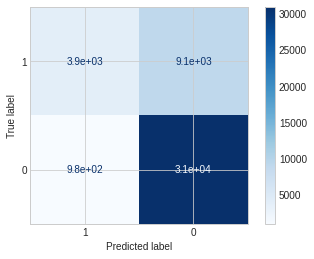

In [257]:
from sklearn.metrics import plot_confusion_matrix

print("Accuracy = {0:.4f}".format(accuracy_score(y_test_clsf,y_test_preds_clsf)))
plot_confusion_matrix(clf, X_test_clsf, y_test_clsf, y_test_clsf.unique(), cmap=plt.cm.Blues);

In [258]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp


,imp,col
23,0.000031,number_of_cash_wd_90_days
21,0.000068,number_of_deposit_90_days
4,0.000087,onboarding
25,0.000104,number_of_wd_90_days
26,0.000164,avg_of_wd_90_days
19,0.000250,number_of_cash_dep_90_days
24,0.000252,avg_of_cash_wd_90_days
20,0.000399,avg_cash_deposit_90_days
22,0.001919,avg_of_dep_90_days
6,0.002046,residentcountry


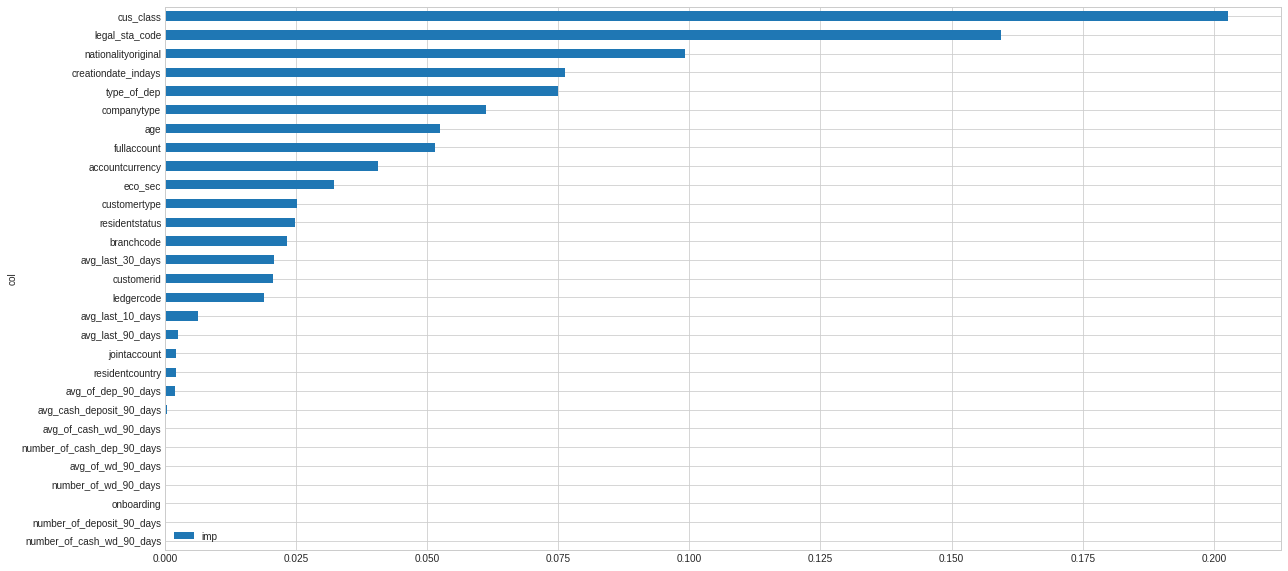

In [259]:
# Plot the feature importance scores
feature_importance(clf, X_train_clsf)

## 6. Regression

In [266]:
df_reg = df.copy()
other_target_reg = ['score_card_e-new','score_card_i-existing', 'score_card_i-new','risk_description']
df_reg = df_reg.drop(columns = other_target_reg)

In [267]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X_reg = dataframe.loc[:, dataframe.columns != 'rbavalue']
    y_reg = dataframe['rbavalue']

    return train_test_split(X_reg, y_reg, test_size=1-percentage, random_state=seed)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_df(df_reg, seed=42, percentage=0.8)

In [268]:
from sklearn.ensemble import RandomForestRegressor
# Fit regression model
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 2,'random_state':42}
clf = RandomForestRegressor(**params)
clf.fit(X_train_reg, y_train_reg)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [269]:
y_train_preds_reg = clf.predict(X_train_reg)
y_test_preds_reg = clf.predict(X_test_reg)

In [270]:
from sklearn.metrics import r2_score
r2_score(y_test_reg, y_test_preds_reg)

0.3826230559615619

,imp,col
4,0.000000,onboarding
25,0.000000,number_of_wd_90_days
21,0.000000,number_of_deposit_90_days
23,0.000000,number_of_cash_wd_90_days
19,0.000000,number_of_cash_dep_90_days
11,0.000000,jointaccount
26,0.000000,avg_of_wd_90_days
22,0.000000,avg_of_dep_90_days
24,0.000000,avg_of_cash_wd_90_days
18,0.000000,avg_last_90_days


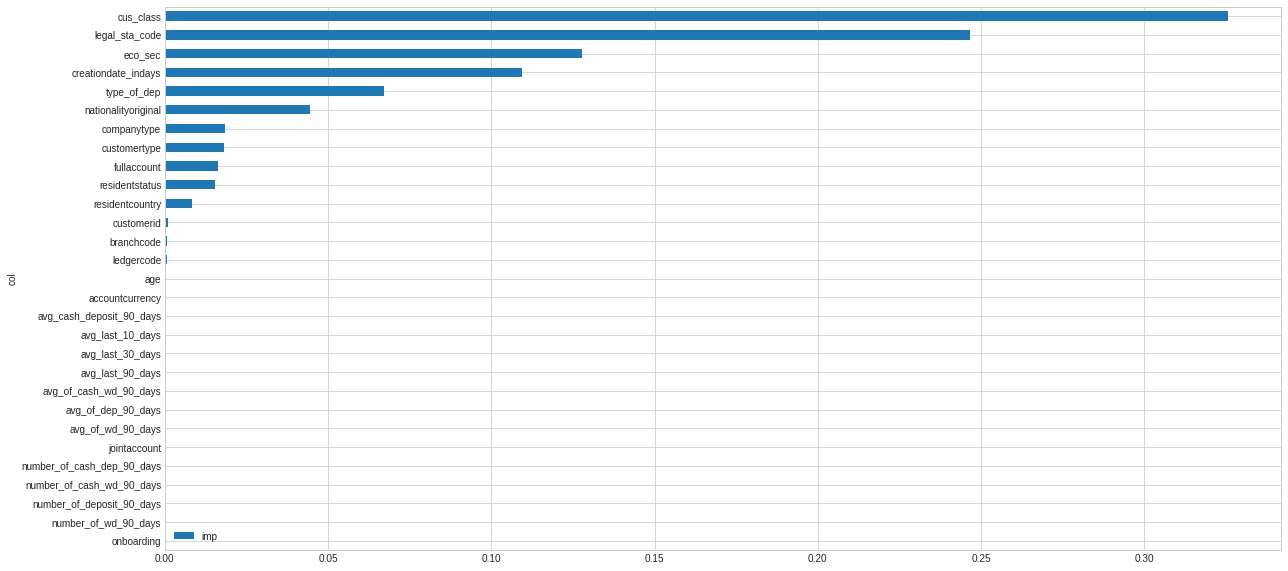

In [271]:
# Plot the feature importance scores
feature_importance(clf, X_train_reg)

# The End